In [3]:
import time
import h5py
import torch
import torch.nn as nn
import torchvision as tv

from torchvision import transforms
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset

import mlflow

import numpy as np
import matplotlib.pyplot as plt

from craterdetection.detection.model import DeepMoon
from craterdetection.detection.training import F1Loss

In [2]:
model = DeepMoon()
model.load_state_dict(torch.load("../blobs/DeepMoon.pth"))
model.cuda()
print('Successful')

Successful


In [3]:
class CraterDataset(Dataset):
    transform = {
        'images': transforms.Compose([
            transforms.ToTensor()
        ])
    }
    def __init__(self, cuda=True):
        images_dataset = np.load("output/test_images.npy").astype(np.float32)
        masks_dataset = np.load("output/test_masks.npy").astype(np.float32)

        self.images = torch.tensor(images_dataset)
        self.masks = torch.tensor(masks_dataset) / 255

        self.n_images = len(self.images)

        self.cuda = cuda

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.cuda:
            return self.images[idx].cuda(), self.masks[idx].cuda()
        else:
            return self.images[idx], self.masks[idx]

    def random(self):
        return self.__getitem__(
            np.random.randint(0, self.n_images)
        )

    def __len__(self):
        return self.n_images

dataset = CraterDataset()
dataloader = DataLoader(dataset, batch_size=12)

In [4]:
images, masks = next(iter(dataloader))
masks[0]

tensor([[[0., 1., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [5]:
loss_function = nn.BCELoss().cuda()

In [ ]:
learning_rate = 1e-2
momentum = 0.9

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [27]:
num_epochs = 6

for e in range(1, num_epochs+1):
    print(f'\n-----Epoch {e} started.-----\n')

    since = time.time()

    train_losses, val_losses = [], []

    model.train()
    for batch, (images, masks) in enumerate(dataloader, 1):

        optimizer.zero_grad()
        logits = model(images)

        loss = loss_function(logits, masks)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if batch % 20 == 0 or batch == 1 or batch==len(dataloader):
            time_elapsed = time.time() - since
            print(
                f'Training loss = {np.average(train_losses):8.3f} | ',
                f'Batch # {batch:6.0f} | [{time_elapsed//60:3.0f}m {time_elapsed%60:2.0f}s]')

    time_elapsed = time.time() - since
    print(
        f"\nSummary:\n",
        f"\tEpoch: {e}/{num_epochs}\n",
        f"\tLearning Rate: {learning_rate}\n",
        f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
    )

    print(f'-----Epoch {e} finished.-----\n')


-----Epoch 1 started.-----

Training loss =    0.143 |  Batch #      1 | [  0m  0s]
Training loss =    0.149 |  Batch #     20 | [  0m  7s]
Training loss =    0.142 |  Batch #     40 | [  0m 15s]
Training loss =    0.139 |  Batch #     60 | [  0m 22s]
Training loss =    0.139 |  Batch #     80 | [  0m 30s]
Training loss =    0.140 |  Batch #    100 | [  0m 37s]
Training loss =    0.140 |  Batch #    120 | [  0m 44s]
Training loss =    0.139 |  Batch #    140 | [  0m 52s]
Training loss =    0.138 |  Batch #    160 | [  0m 59s]
Training loss =    0.139 |  Batch #    180 | [  1m  7s]
Training loss =    0.140 |  Batch #    200 | [  1m 14s]
Training loss =    0.140 |  Batch #    220 | [  1m 21s]
Training loss =    0.141 |  Batch #    240 | [  1m 28s]
Training loss =    0.142 |  Batch #    250 | [  1m 31s]

Summary:
 	Epoch: 1/6
 	Learning Rate: 0.01
 	Duration: 1m 31s
-----Epoch 1 finished.-----


-----Epoch 2 started.-----

Training loss =    0.142 |  Batch #      1 | [  0m  0s]
Training 

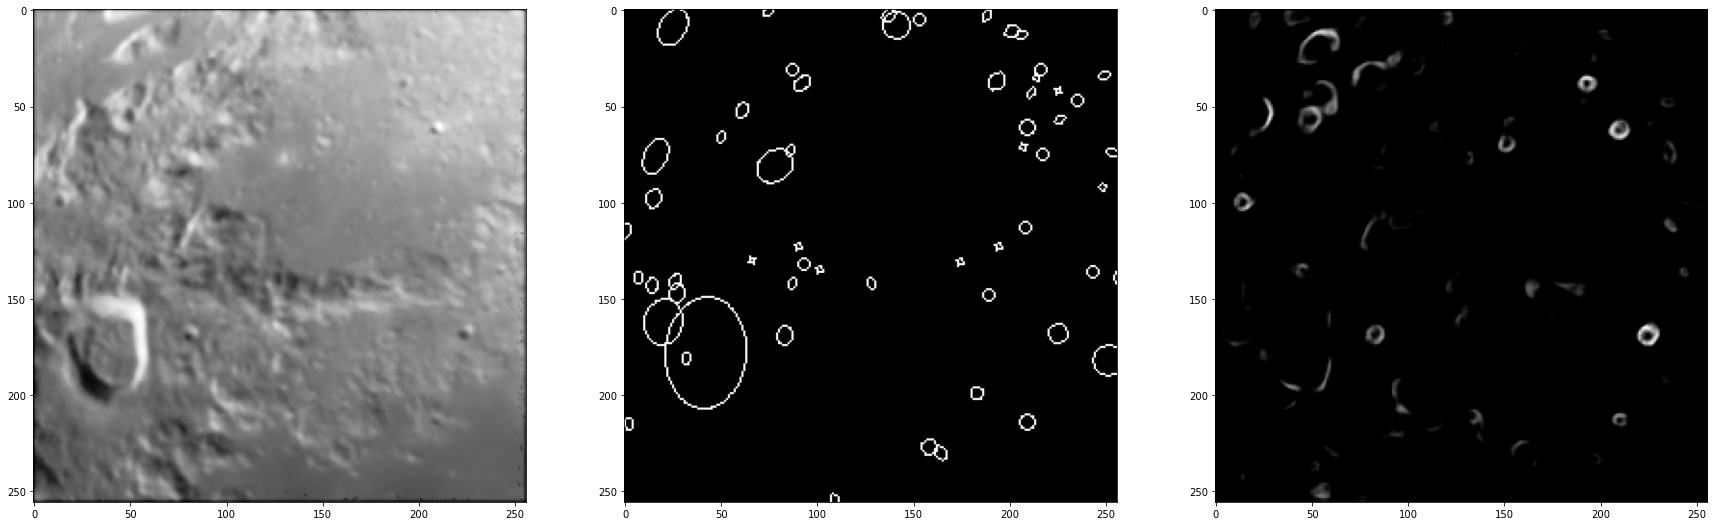

In [28]:
images, masks = next(iter(dataloader))
model.eval()
with torch.no_grad():
    out = model(images)

i = 1
fig, axes = plt.subplots(1, 3, figsize=(30,10))

axes[0].imshow(images[i, 0].cpu().numpy(), cmap='Greys_r')
axes[1].imshow(masks[i, 0].cpu().numpy(), cmap='Greys_r')
axes[2].imshow(out[i, 0].clamp(0.1).cpu().numpy(), cmap='Greys_r')

In [31]:
f1_score = F1Loss().cuda()
f1_score(out, masks)

AssertionError: 